In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list(),
    output = list('results/mars.RData'),
    params = list(),
    wildcards = list(),
    threads = 1,
    log = list('logs/mars.log', 'logs/mars.ipynb', "notebook" = 'logs/mars.ipynb'),
    resources = list(),
    config = list(),
    rule = 'mars',
    bench_iteration = 0,
    scriptdir = '/Users/tsuyusakikouki/Desktop/elwood/Dev/preprocess-exercise/notebooks',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/Users/tsuyusakikouki/Desktop/elwood/Dev/preprocess-exercise');

######## snakemake preamble end #########


## Package loading

In [2]:
source("src/functions.R")

── Attaching packages ────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR

# Data download

In [3]:
download.file("http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE54006&format=file&file=GSE54006%5Fumitab%2Etxt%2Egz",
	destfile="data/count.txt.gz") # Gene Expression data
download.file("http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE54006&format=file&file=GSE54006%5Fexperimental%5Fdesign%2Etxt%2Egz",
	destfile="data/expdesign.txt.gz") # Experimental Information data

# Data loading

In [4]:
count <- read.table("data/count.txt.gz", row.names=1, header=TRUE, sep="\t")
expdesign <- read.table("data/expdesign.txt.gz", row.names=1, header=TRUE,
	sep="\t", skip=6, stringsAsFactors = FALSE)

# Wild -> Long

In [5]:
# Merge
# Filtering non single-cells / zero count cells
count %>%
	rownames_to_column("gene") %>%
		pivot_longer(-gene, names_to="cell", values_to="exp") %>%
			mutate(cell = str_replace(cell, "^X", "")) %>%
				inner_join(expdesign,
					by=c("cell"="Column_name_in_processed_data_file")) %>%
					rename_all(tolower) %>%
						group_by(cell) %>%
							mutate(sum=sum(exp)) %>%
									filter(sum != 0 &&
										number_of_cells == 1 &&
										group_name %in%
											c("B cell", "CD8+pDC",
												"monocyte_or_neutrophil", "NK_cell")) %>%
											ungroup %>%
												arrange(cell) -> marsdata

# Long -> Wild

In [6]:
# Extract gene expression part
marsdata %>%
	select(gene, cell, exp) %>%
		pivot_wider(names_from="cell", values_from="exp") -> wild_marsdata
# Gene name
wild_marsdata %>%
	select(gene) %>%
		data.frame %>%
			.[,1] -> genename
# Expression matrix -> SingleCellExperiment
wild_marsdata %>%
	select(!gene) %>%
		as.matrix %>%
			SingleCellExperiment(assays=list(counts=.[])) -> sce_marsdata
# rownames
genename -> rownames(sce_marsdata)
# coldata
marsdata %>%
	select(!c(gene, exp)) %>%
		distinct %>%
			arrange(cell) %>%
				DataFrame -> colData(sce_marsdata)

# scater

In [7]:
# Analysis workflow of scater
sce_marsdata %>%
	logNormCounts %>%
		runPCA(ntop=2000, ncomponents=10) %>%
			runTSNE(dimred = "PCA") %>%
				runUMAP(dimred = "PCA") -> sce_marsdata
# save
save(sce_marsdata, file="results/mars.RData")

# Visualization

## Standard plot functions of R

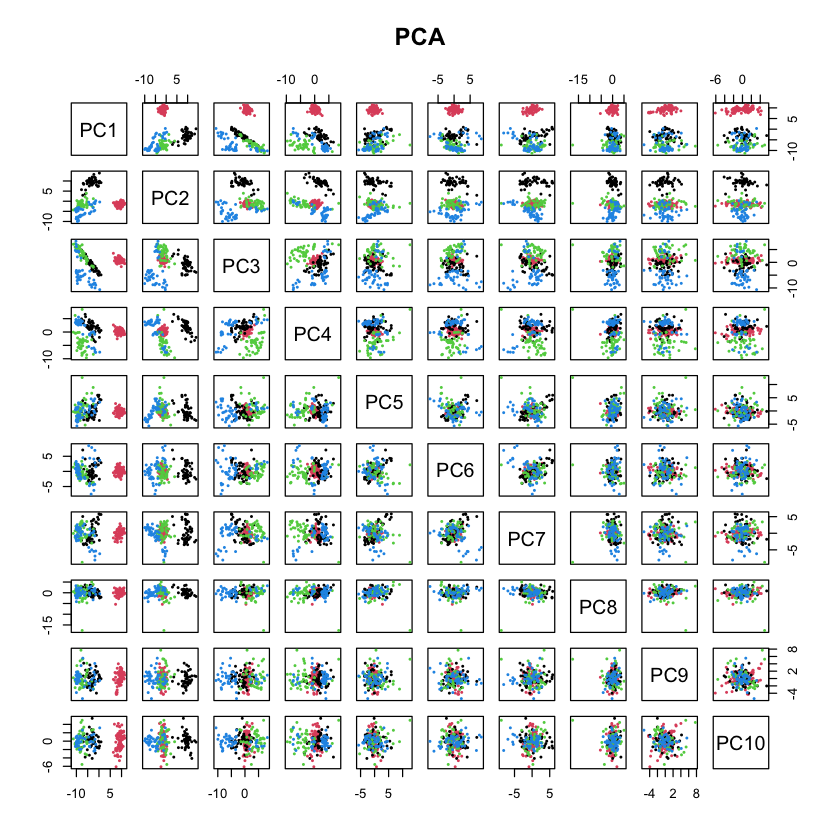

In [8]:
pairs(reducedDim(sce_marsdata, "PCA"),
	col=factor(colData(sce_marsdata)$group_name),
	pch=16, cex=0.5, main="PCA")

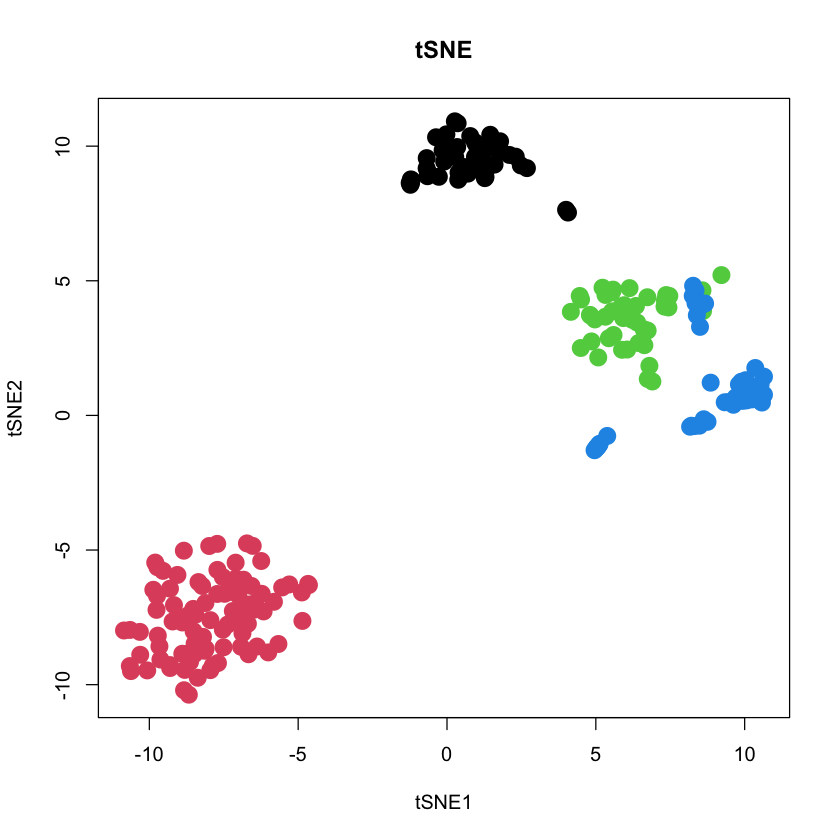

In [9]:
plot(reducedDim(sce_marsdata, "TSNE"),
	col=factor(colData(sce_marsdata)$group_name),
	xlab="tSNE1", ylab="tSNE2",
	pch=16, cex=2, main="tSNE")

## Pair/scatter plot (scater)

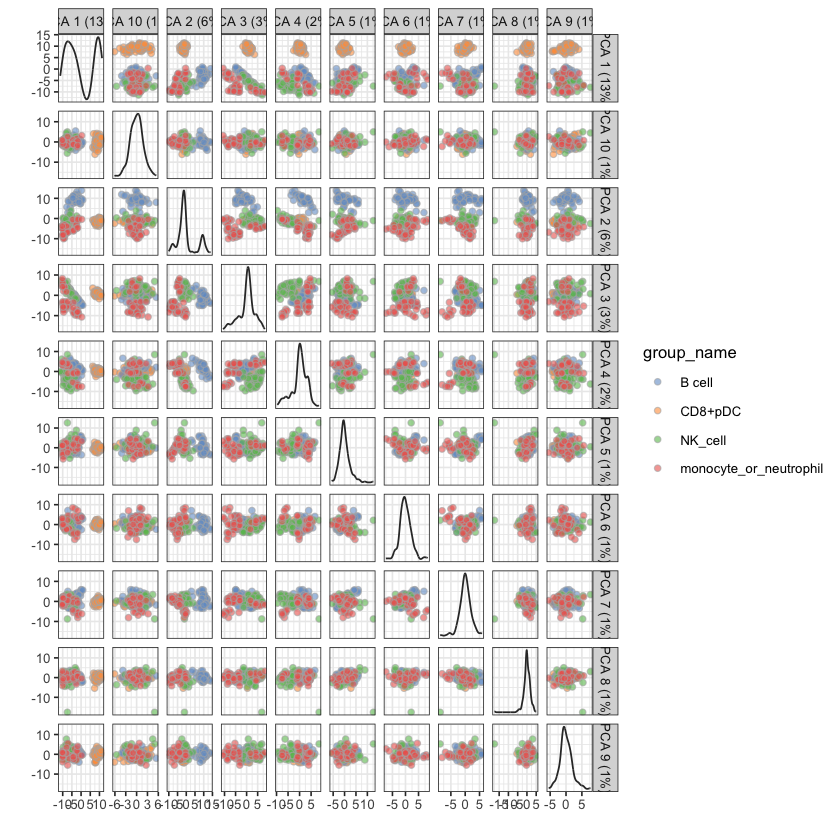

In [10]:
sce_marsdata %>%
	plotReducedDim(dimred="PCA", colour_by="group_name", ncomponents=10)

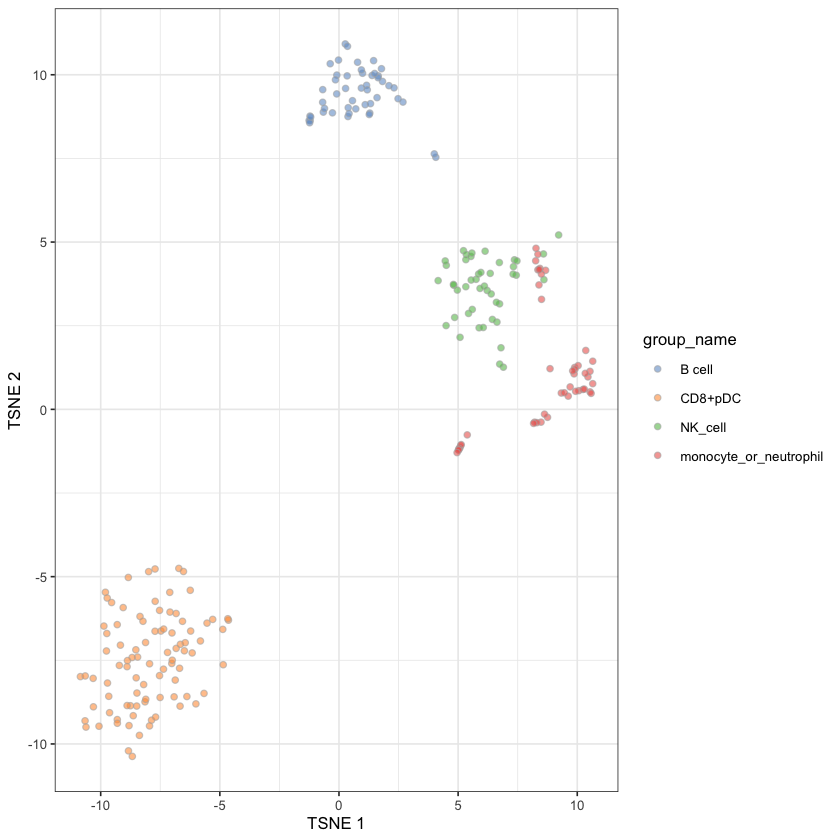

In [11]:
sce_marsdata %>%
	plotReducedDim(dimred="TSNE", colour_by="group_name")

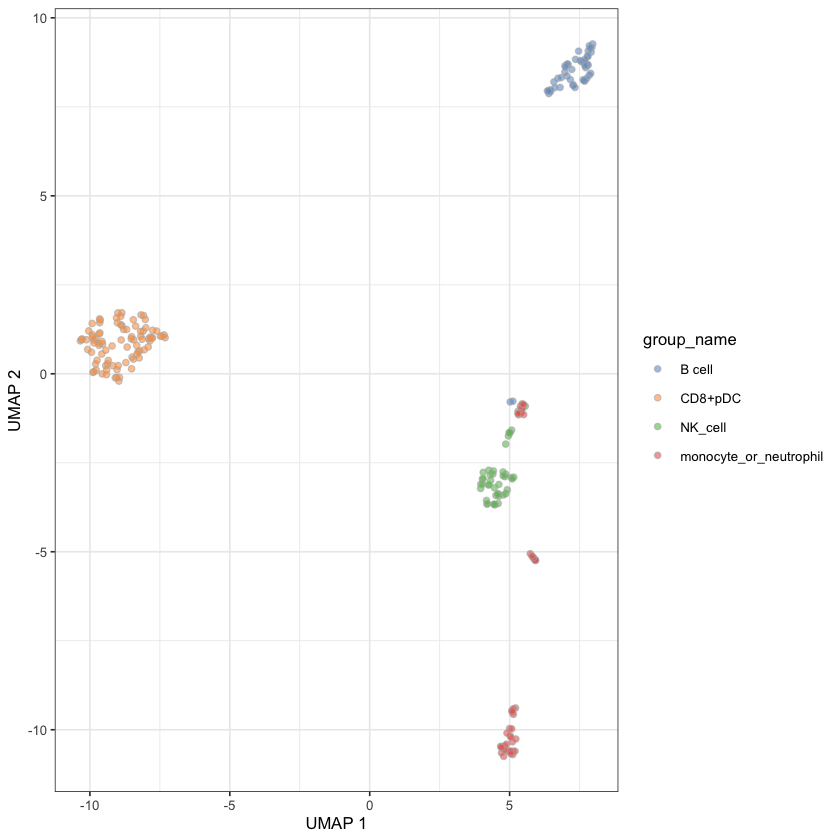

In [12]:
sce_marsdata %>%
	plotReducedDim(dimred="UMAP", colour_by="group_name")

## ggplot2

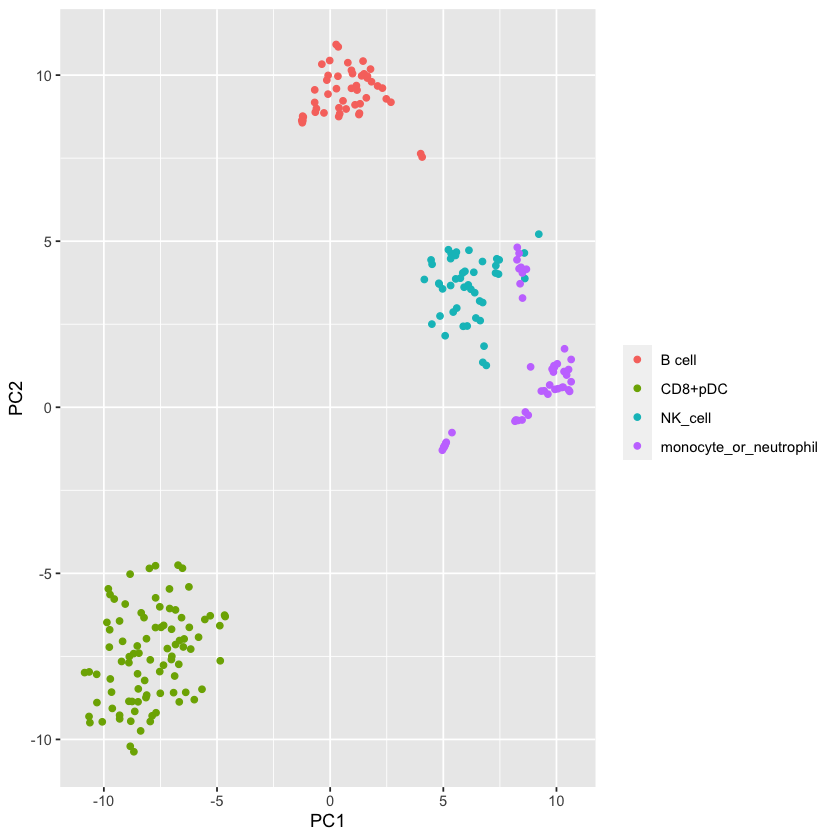

In [13]:
reducedDim(sce_marsdata, "TSNE") %>%
	cbind(colData(sce_marsdata)$group_name) %>%
		data.frame %>%
			mutate_at(vars(-X3), as.numeric) %>%
			ggplot(aes(x=X1, y=X2, color=X3)) +
				geom_point() +
					xlab("PC1") +
						ylab("PC2") +
							theme(legend.title = element_blank())

## ggpairs

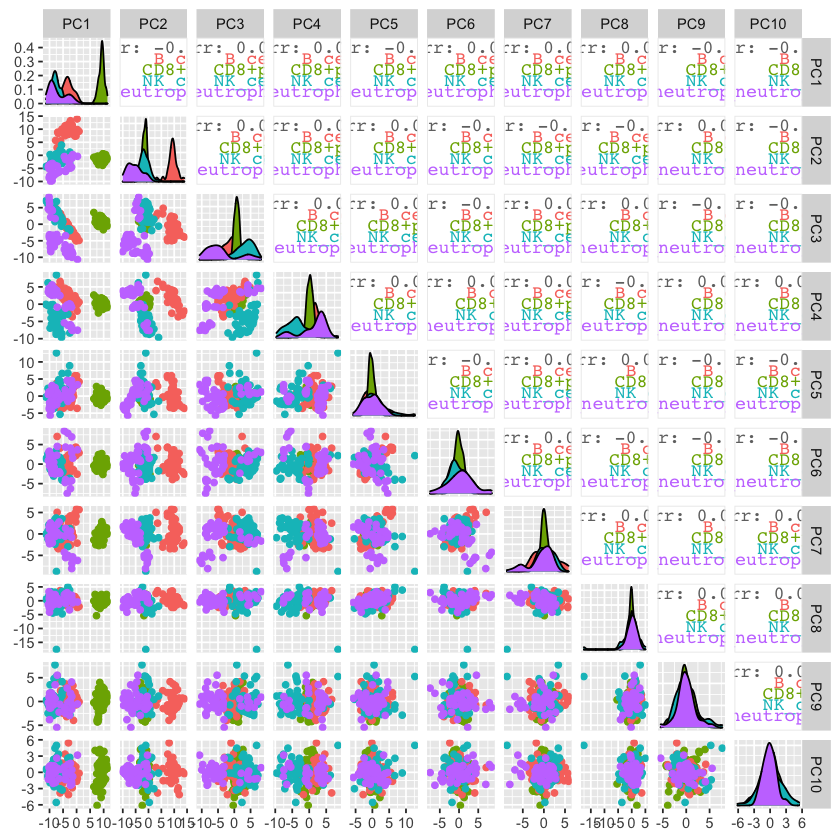

In [14]:
reducedDim(sce_marsdata, "PCA") %>%
	cbind(colData(sce_marsdata)$group_name) %>%
		data.frame %>%
			mutate_at(vars(-V11), as.numeric) %>%
			ggpairs(columns=1:10, aes(color=V11))

## pairsD3

In [15]:
# reducedDim(sce_marsdata, "PCA") %>%
# 	.[,1:5] %>%
# 		pairsD3(group=colData(sce_marsdata)$group_name,
# 			tooltip=colData(sce_marsdata)$cell)

## Plotly

In [16]:
# reducedDim(sce_marsdata) %>%
# 	as_tibble %>%
# 		select(PC1, PC2, PC8) %>%
# 			data.frame %>%
# 				plot_ly(x=~PC1, y=~PC2, z=~PC8,
# 			    type = "scatter3d", mode = "markers",
# 			    text = colData(sce_marsdata)$cell,
# 			    color =~colData(sce_marsdata)$group_name
# 			    )

## iSEE

In [17]:
# app <- iSEE(sce_marsdata)
# runApp(app)

# Session Information

In [18]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS/LAPACK: /Users/tsuyusakikouki/opt/anaconda3/envs/r-4.0/lib/libopenblasp-r0.3.10.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] pairsD3_0.1.0               shiny_1.5.0                
 [3] iSEE_2.0.0                  plotly_4.9.2.1             
 [5] GGally_2.0.0                scater_1.16.0              
 [7] SingleCellExperiment_1.10.1 SummarizedExperiment_1.18.1
 [9] DelayedArray_0.14.0         matrixStats_0.57.0         
[11] Biobase_2.48.0              GenomicRanges_1.40.0       
[13] GenomeInfoDb_1.24.0         IRanges_2.22.1             
[15] S4Vectors_0.26.0            BiocGenerics_0.34.0        
[17] forcats_0.5.0               stringr_1.4.0              
[19] dplyr_1.0.2                 purrr_0.3.4